<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
!pip uninstall -y tensorflow 
!pip install tensorflow==2.4.3 > /dev/null 2>&1

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Tensorflow version 2.4.3
Running on TPU  ['10.73.22.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.73.22.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.22.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

 80% 60.0M/75.4M [00:00<00:00, 81.9MB/s]
100% 75.4M/75.4M [00:00<00:00, 103MB/s] 
 98% 137M/139M [00:00<00:00, 106MB/s]
100% 139M/139M [00:01<00:00, 143MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 139MB/s]
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

***

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

***
## data preparation

In [6]:
SEQ_LEN = 80

In [7]:
train_raw = pd.read_csv(f'{input_path}/train.csv')
test_raw = pd.read_csv(f'{input_path}/test.csv')
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

In [8]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )

In [9]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

train = add_features(train_raw)
test = add_features(test_raw)

In [10]:
# def compute_feats(dataframe):
#     dataframe = dataframe.copy()

#     # time features
#     dataframe["time_diff"] = dataframe.groupby("breath_id")["time_step"].diff()
#     dataframe['time_since_expiratory']= dataframe['time_step'] * dataframe['u_out']

#     # lag features
#     lags = [1,2]
#     for lag in lags:
#         dataframe[f"u_in_lag{lag}"] = dataframe.groupby("breath_id")["u_in"].shift(lag).fillna(0)

#     # stats on u_in
#     dataframe["u_in_cumsum"] = dataframe.groupby("breath_id")["u_in"].cumsum()
#     dataframe['u_in_cummean'] =dataframe['u_in_cumsum'] / (dataframe.groupby("breath_id")["id"].cumcount()+1)
#     #dataframe['u_in_last'] = dataframe.groupby('breath_id')['u_in'].transform('last')
#     dataframe['cross1']= dataframe['u_in'] * dataframe['u_out']
#     dataframe['cross2']= dataframe['u_in'] * (1 - dataframe['u_out'])

#     dataframe['area'] = dataframe['time_step'] * dataframe['u_in']
#     dataframe['area'] = dataframe.groupby('breath_id')['area'].cumsum()
    
#     dataframe['vol_diff'] = (dataframe['time_diff']*dataframe['u_in']).fillna(0)
#     dataframe['vol_diff_cumsum'] = dataframe.groupby('breath_id')['vol_diff'].cumsum()

#     # gradients of u_in
#     def compute_grad_1st(df):
#         return np.gradient(df.u_in, 100*df.time_step)
#     def compute_grad_2nd(df):
#         return np.gradient(df.grad_1st, 100*df.time_step)

#     gb_result = dataframe.groupby("breath_id").apply(compute_grad_1st)
#     dataframe["grad_1st"] = np.concatenate(gb_result.values)
#     gb_result = dataframe.groupby("breath_id").apply(compute_grad_2nd)
#     dataframe["grad_2nd"] = np.concatenate(gb_result.values)

#     # nan filling
#     dataframe["time_diff"] = dataframe["time_diff"].fillna(method="bfill")
    
#     # ohe of R&C values    
#     dataframe['R'] = dataframe['R'].astype(str)
#     dataframe['C'] = dataframe['C'].astype(str)
#     dataframe['RC'] = dataframe['R']+dataframe['C']
#     dataframe = pd.get_dummies(dataframe)
#     return dataframe

# train = compute_feats(train_raw)
# test  = compute_feats(test_raw)

In [11]:
targets = train[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

cols_to_exclude_train = exclude = ["id","breath_id","pressure"]
cols_to_exclude_test = exclude = ["id","breath_id",]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

In [12]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [13]:
train = train.reshape(-1, SEQ_LEN, train.shape[-1])
test = test.reshape(-1, SEQ_LEN, train.shape[-1])

***
## model training

In [14]:
def build_model(input_dim):
    with tpu_strategy.scope():   
        inputs = layers.Input(shape = input_dim)

        #h1 = layers.Dense(256, activation = 'selu')(inputs)
        #h2 = layers.Dense(512, activation = 'selu')(h1)
        #h3 = layers.Dense(1024, activation = 'swish')(h2)
    
        h1 = layers.Bidirectional(layers.LSTM(1024, return_sequences=True))(inputs)
        h2 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(h1)
        h3 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(h2)
        h4 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(h3) 
                
        #hcat = layers.Concatenate()([h4,h6])
        #hcat = layers.Dropout(0.1)(hcat)

        out = layers.Dense(128, activation = 'selu')(h4)
        out = layers.Dense(1)(out)
        
        model = keras.Model(inputs, out)
        model.compile(optimizer="adam", loss="mae")
           
    return model  

----------------------------------- Fold: 1 ------------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 256)           656384    
_________________________________________________________________
dense (Dense)                (None, 80, 128)           32896     
______________________________________________

None

Epoch 1/300
59/59 [==============================] - 68s 657ms/step - loss: 4.4384 - val_loss: 1.4158
Epoch 2/300
59/59 [==============================] - 12s 207ms/step - loss: 1.1928 - val_loss: 0.7627
Epoch 3/300
59/59 [==============================] - 12s 206ms/step - loss: 0.7926 - val_loss: 0.6948
Epoch 4/300
59/59 [==============================] - 12s 206ms/step - loss: 0.6662 - val_loss: 0.6106
Epoch 5/300
59/59 [==============================] - 12s 206ms/step - loss: 0.6057 - val_loss: 0.5134
Epoch 6/300
59/59 [==============================] - 12s 206ms/step - loss: 0.5074 - val_loss: 0.4604
Epoch 7/300
59/59 [==============================] - 12s 205ms/step - loss: 0.4792 - val_loss: 0.4461
Epoch 8/300
59/59 [==============================] - 12s 205ms/step - loss: 0.4581 - val_loss: 0.4700
Epoch 9/300
59/59 [==============================] - 12s 206ms/step - loss: 0.4381 - val_loss: 0.4024
Epoch 10/300
59/59 [==============================] - 12s 211ms/step - loss: 0.414

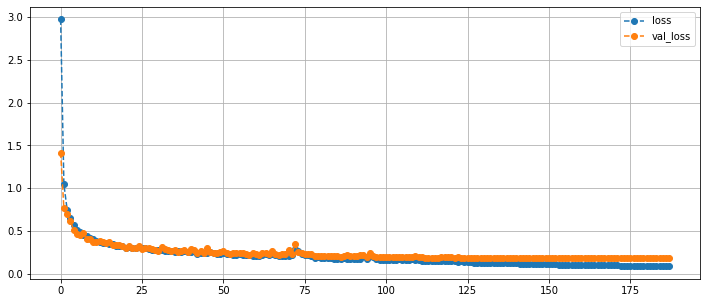

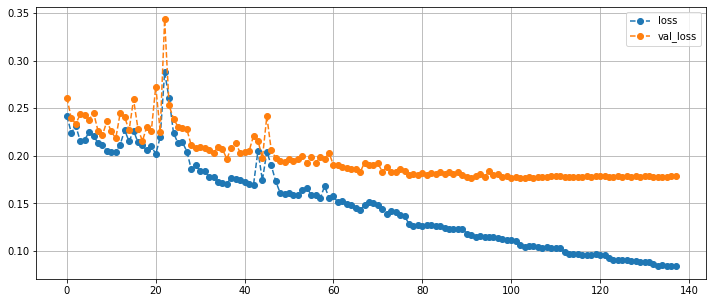

----------------------------------- Fold: 2 ------------------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 80, 256)           656384    
_________________________________________________________________
dense_2 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 67s 654ms/step - loss: 4.4752 - val_loss: 1.7385
Epoch 2/300
59/59 [==============================] - 12s 208ms/step - loss: 1.2718 - val_loss: 0.8276
Epoch 3/300
59/59 [==============================] - 12s 209ms/step - loss: 0.8015 - val_loss: 0.6507
Epoch 4/300
59/59 [==============================] - 12s 209ms/step - loss: 0.6347 - val_loss: 0.6188
Epoch 5/300
59/59 [==============================] - 12s 208ms/step - loss: 0.5731 - val_loss: 0.5149
Epoch 6/300
59/59 [==============================] - 12s 207ms/step - loss: 0.5413 - val_loss: 0.4735
Epoch 7/300
59/59 [==============================] - 12s 207ms/step - loss: 0.4700 - val_loss: 0.4412
Epoch 8/300
59/59 [==============================] - 13s 216ms/step - loss: 0.4411 - val_loss: 0.4757
Epoch 9/300
59/59 [==============================] - 12s 208ms/step - loss: 0.4247 - val_loss: 0.4106
Epoch 10/300
59/59 [==============================] - 12s 208ms/step - loss: 0.418

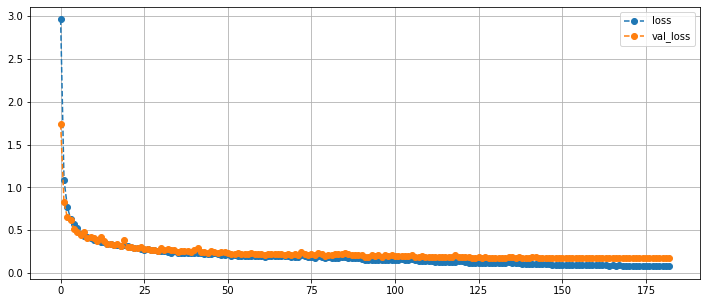

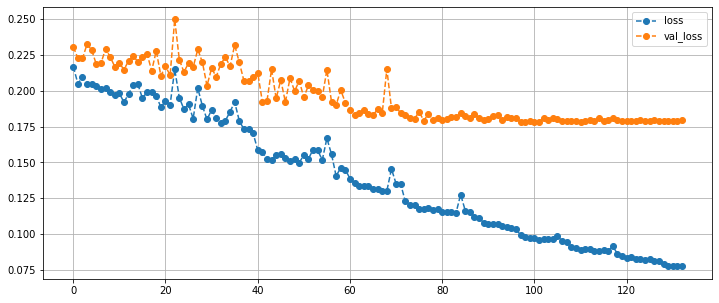

----------------------------------- Fold: 3 ------------------------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_4 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 70s 669ms/step - loss: 4.3997 - val_loss: 1.2048
Epoch 2/300
59/59 [==============================] - 12s 208ms/step - loss: 1.0905 - val_loss: 0.7602
Epoch 3/300
59/59 [==============================] - 12s 207ms/step - loss: 0.7559 - val_loss: 0.6063
Epoch 4/300
59/59 [==============================] - 12s 208ms/step - loss: 0.6172 - val_loss: 0.5587
Epoch 5/300
59/59 [==============================] - 12s 207ms/step - loss: 0.5357 - val_loss: 0.5064
Epoch 6/300
59/59 [==============================] - 12s 209ms/step - loss: 0.5378 - val_loss: 0.4685
Epoch 7/300
59/59 [==============================] - 12s 208ms/step - loss: 0.4671 - val_loss: 0.4948
Epoch 8/300
59/59 [==============================] - 12s 207ms/step - loss: 0.4652 - val_loss: 0.4116
Epoch 9/300
59/59 [==============================] - 12s 207ms/step - loss: 0.4234 - val_loss: 0.3912
Epoch 10/300
59/59 [==============================] - 12s 207ms/step - loss: 0.401

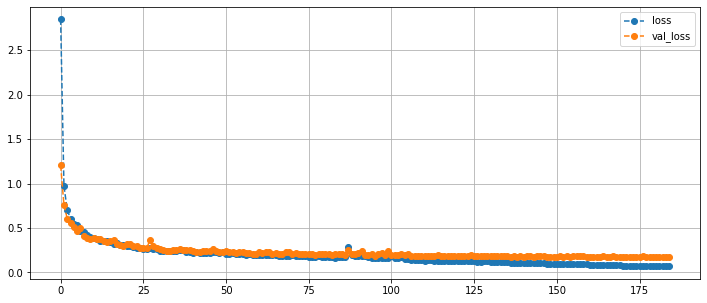

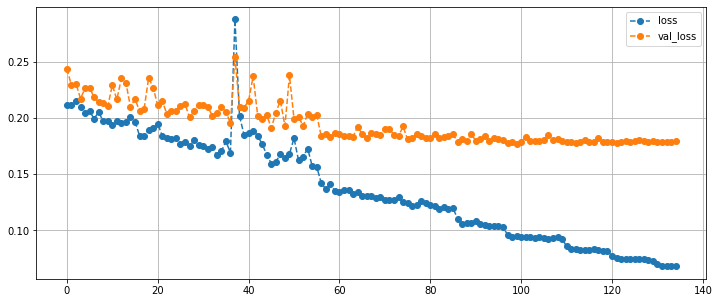

----------------------------------- Fold: 4 ------------------------------------
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_6 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 70s 670ms/step - loss: 3.9768 - val_loss: 1.0302
Epoch 2/300
59/59 [==============================] - 12s 206ms/step - loss: 1.0183 - val_loss: 0.8264
Epoch 3/300
59/59 [==============================] - 12s 206ms/step - loss: 0.7379 - val_loss: 0.5896
Epoch 4/300
59/59 [==============================] - 12s 207ms/step - loss: 0.6010 - val_loss: 0.5677
Epoch 5/300
59/59 [==============================] - 12s 206ms/step - loss: 0.5577 - val_loss: 0.5122
Epoch 6/300
59/59 [==============================] - 12s 206ms/step - loss: 0.4912 - val_loss: 0.4459
Epoch 7/300
59/59 [==============================] - 12s 206ms/step - loss: 0.4450 - val_loss: 0.4236
Epoch 8/300
59/59 [==============================] - 12s 206ms/step - loss: 0.4420 - val_loss: 0.4454
Epoch 9/300
59/59 [==============================] - 12s 206ms/step - loss: 0.4354 - val_loss: 0.3824
Epoch 10/300
59/59 [==============================] - 12s 206ms/step - loss: 0.382

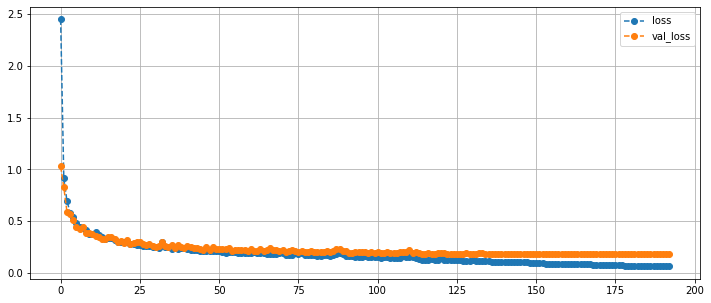

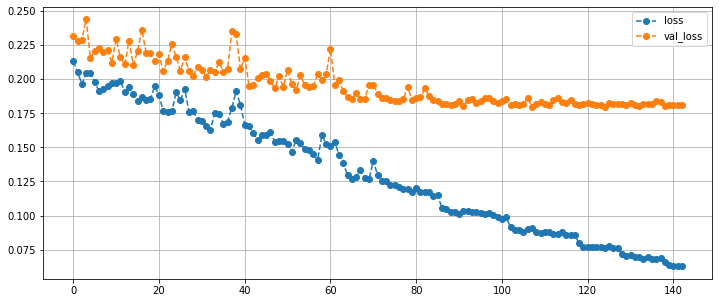

----------------------------------- Fold: 5 ------------------------------------
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_8 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 67s 662ms/step - loss: 4.3551 - val_loss: 1.5286
Epoch 2/300
59/59 [==============================] - 12s 207ms/step - loss: 1.2829 - val_loss: 0.8457
Epoch 3/300
59/59 [==============================] - 12s 207ms/step - loss: 0.7702 - val_loss: 0.6286
Epoch 4/300
59/59 [==============================] - 12s 207ms/step - loss: 0.6442 - val_loss: 0.5684
Epoch 5/300
59/59 [==============================] - 12s 207ms/step - loss: 0.5730 - val_loss: 0.5011
Epoch 6/300
59/59 [==============================] - 12s 207ms/step - loss: 0.5115 - val_loss: 0.5060
Epoch 7/300
59/59 [==============================] - 12s 207ms/step - loss: 0.4773 - val_loss: 0.5206
Epoch 8/300
59/59 [==============================] - 12s 207ms/step - loss: 0.4485 - val_loss: 0.4455
Epoch 9/300
59/59 [==============================] - 12s 207ms/step - loss: 0.4219 - val_loss: 0.3990
Epoch 10/300
59/59 [==============================] - 12s 206ms/step - loss: 0.399

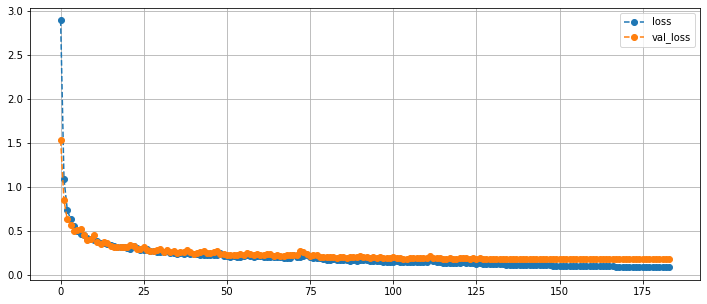

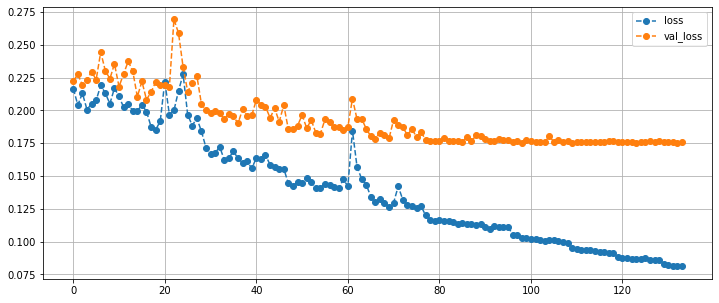

In [15]:
EPOCH = 300
BATCH_SIZE = 1024

kf = KFold(n_splits=5, shuffle=True, random_state=2021)
models_by_fold = list()

oof = train_raw[["id","breath_id","u_out","pressure"]].copy()

for fold, (train_idx,valid_idx) in enumerate(kf.split(train, targets)):

    print(f" Fold: {fold+1} ".center(80, "-"))
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = targets[train_idx], targets[valid_idx]
    
    model = build_model(input_dim=train.shape[-2:])
    display(model.summary())

    #scheduler = ExponentialDecay(
    #    initial_learning_rate=1e-3, 
    #    decay_steps=EPOCH*((len(train)*0.8)/BATCH_SIZE), 
    #    decay_rate=1e-5
    #)
    #lr = LearningRateScheduler(scheduler, verbose=1)
    #lr = OneCycleScheduler(
    #    lr_max = 1e-3,
    #    steps = EPOCH*(X_train.shape[0]/BATCH_SIZE),
    #    phase_1_pct = 0.2,
    #    init_div_factor = 1e1,
    #    final_div_factor = 1e2,
    #)
    lr = ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.8, 
        patience=10, 
        verbose=1
    )
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=35, 
        verbose=1,
        restore_best_weights=True,
    )
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        callbacks=[lr,es],
        verbose=1,
    )
    models_by_fold.append(model)

    # generate the oof predictions
    x_valid_tf = tf.convert_to_tensor(X_valid, dtype=tf.float32)
    oof_preds = model.call(x_valid_tf, training=False).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()

    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"], "o--", label="loss")
    plt.plot(history.history["val_loss"], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"][50:], "o--", label="loss")
    plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()


In [16]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.17478381765716353
mae inspiratory: 0.1884791864930153
mae expiratory : 0.16640587809591878


lstm_v7
- mae: 0.17478381765716353
- mae inspiratory: 0.1884791864930153
- mae expiratory : 0.16640587809591878

lstm_v6
- mae: 0.1700748569735916
- mae inspiratory: 0.18324426831174476
- mae expiratory : 0.16202780215683016

lstm_v5
- mae: 0.19870362716674497
- mae inspiratory: 0.24693164942887788
- mae expiratory : 0.169200847028661

lstm_v4
- mae: 0.19910630745529212
- mae inspiratory: 0.24139623415898287
- mae expiratory : 0.1732360695506279

lstm_v3
- mae: 0.1894350191416654
- mae inspiratory: 0.22527142074094628
- mae expiratory : 0.16751262988059495

lstm_v2
- mae: 0.20938487189579605
- mae inspiratory: 0.2124941942660988
- mae expiratory : 0.19958701148249222

lstm_v1
- mae: 0.18086928169783648
- mae inpiratory: 0.2031012730817264
- mae expiratory: 0.16726918940573152

***
## sub generation

In [17]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in models_by_fold:
    preds = model.call(test_tf, training=False).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.mean(all_preds, axis=0)

In [18]:
# saves final sub
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_lstm.csv", index=False)

In [19]:
# saves oof preds
oof.to_csv(f"{results_path}/oof_lstm.csv", index=False)

In [20]:
# saves each model preds (pseudo labels)
for fold,preds in enumerate(all_preds):
    _sub = submission.copy()
    _test = test_raw[["id","pressure"]].copy()
    _test["pressure"] = preds
    _sub = pd.merge(_sub["id"], _test[["id","pressure"]], how="left", on="id")
    _sub["pressure"] = _sub["pressure"].fillna(0)
    _sub.to_csv(f"{results_path}/plabels_lstm_{fold}.csv", index=False)

***